## Data Distribution

In [1]:
import pandas as pd
import numpy as np
import librosa
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from CNN.utility import train_routine
from CNN.loader import load_dataset, get_split
from sklearn.manifold import TSNE
import seaborn as sns


SPLIT_PERC = {'train': 0.8, 'val': 0.2}
DATA_DIR = os.path.join('data', 'mammals_calls')
AUDIO_DIR = os.path.join('data', 'audio')
TO_TRAIN = True
h = 164
w = 397

seed = 2025
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2025-09-16 13:27:36.827019: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-16 13:27:36.840235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758022056.855708   14692 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758022056.860568   14692 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758022056.872962   14692 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

No GPU found, using CPU
No GPU found, using CPU


2025-09-16 13:27:39.128007: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
subfolders = [f.path for f in os.scandir(DATA_DIR) if f.is_dir()]
data_info = {}
for subfolder in subfolders:
    species_name = os.path.basename(subfolder)
    file_count = len([f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))])
    data_info[species_name] = file_count
count_df = pd.DataFrame(list(data_info.items()), columns=['species', 'file_count'])
count_df = count_df.sort_values(by='file_count', ascending=False)


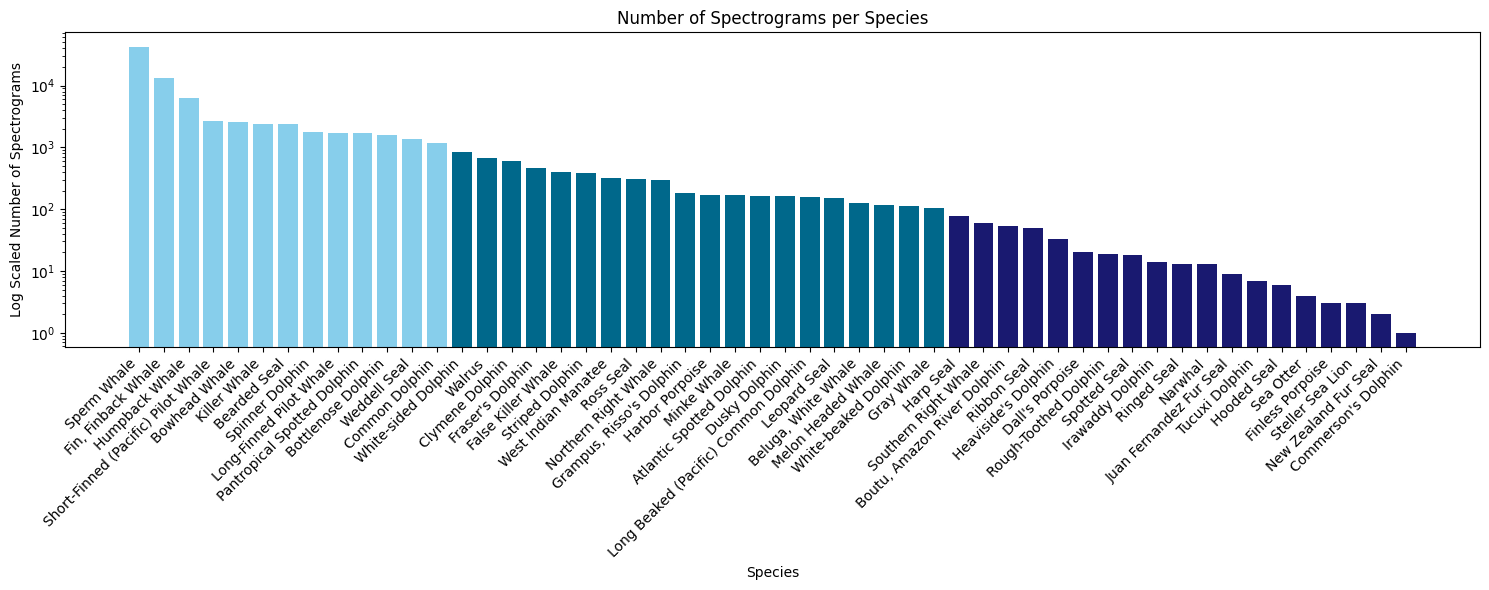

Total number of species: 52
                               species  file_count
16                         Sperm Whale       42634
13                  Fin, Finback Whale       13272
46                      Humpback Whale        6279
19  Short-Finned (Pacific) Pilot Whale        2662
10                       Bowhead Whale        2554
9                         Killer Whale        2386
50                        Bearded Seal        2366
47                     Spinner Dolphin        1757
5              Long-Finned Pilot Whale        1684
36         Pantropical Spotted Dolphin        1679
48                  Bottlenose Dolphin        1611
15                        Weddell Seal        1352
40                      Common Dolphin        1175
Number of species with more than 1000 spectrograms: 13
Number of species with more than 100 but less than 1000 spectrograms: 20
Number of species with less than 100 spectrograms: 19


In [3]:
count_thousands = count_df[count_df['file_count'] > 1000]
count_hundreds = count_df[(count_df['file_count'] > 100) & (count_df['file_count'] < 1000)]
count_tens = count_df[count_df['file_count'] < 100]

plt.figure(figsize=(15, 6))
plt.bar(count_thousands['species'], count_thousands['file_count'], color="#87CEEB")
plt.bar(count_hundreds['species'], count_hundreds['file_count'], color='#00688B')
plt.bar(count_tens['species'], count_tens['file_count'], color="#191970")
plt.xlabel('Species')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Log Scaled Number of Spectrograms')
plt.yscale("log")
plt.title('Number of Spectrograms per Species')

plt.tight_layout()
plt.show()

print(f'Total number of species: {count_df.shape[0]}')
print(count_thousands)
print(f'Number of species with more than 1000 spectrograms: {count_thousands.shape[0]}')
print(f'Number of species with more than 100 but less than 1000 spectrograms: {count_hundreds.shape[0]}')
print(f'Number of species with less than 100 spectrograms: {count_tens.shape[0]}')


In [12]:
def mfcc_extractor(row, chunk_size):
    try:
        signal, sr = librosa.load(row['audio_files'])
    except Exception as e:
        print(f"Error loading audio file {row['audio_files']}: {e}")
        row['chunk_list'] = []
        return row
    chunk_size = chunk_size * sr
    mfcc_chunks = []
    i = 1
    
    for start in range(0, len(signal), sr):
        i += 1
        end = start + chunk_size
        y_chunk = signal[start:end]
        
        if len(y_chunk) < chunk_size:
            break  
        mfcc = librosa.feature.mfcc(y=y_chunk, sr=sr, n_mfcc=50)
        mfcc_mean = np.mean(mfcc, axis=1)

        mfcc_chunks.append(mfcc_mean)
    row['chunk_list'] = mfcc_chunks
    return row

In [ ]:
n = 1700
audio_files = {}
for species in count_thousands['species']:
    curr_path = os.path.join(AUDIO_DIR, species)
    audio_files[species] = [os.path.join(curr_path, f) for f in os.listdir(curr_path) if f.endswith('.wav')]

audio_df = pd.DataFrame(list(audio_files.items()), columns=['species', 'audio_files'])
audio_df = audio_df.explode('audio_files').reset_index(drop=True)

audio_df = audio_df.apply(mfcc_extractor, axis=1, chunk_size=2)
audio_df_exploded = audio_df.explode('chunk_list').reset_index(drop=True)

print(f'Different species in audio dataset: {audio_df_exploded["species"].nunique()}')

In [4]:
print(f'Different species in audio dataset: {audio_df_exploded["species"].unique()}')
print(audio_df_exploded.head())

NameError: name 'audio_df_exploded' is not defined

In [15]:
# eliminare le righe con liste vuote in 'chunk_list'
audio_df_exploded_clean = audio_df_exploded.dropna(axis=0, subset=['chunk_list'])
valid_chunks = audio_df_exploded_clean['chunk_list']
valid_chunks = valid_chunks[valid_chunks.apply(lambda x: isinstance(x, np.ndarray) and len(x) == 50)]

# Converti in matrice
mfcc_matrix = np.array(valid_chunks.tolist())

tsne = TSNE(n_components=2, random_state=42)
    
x_transformed = tsne.fit_transform(mfcc_matrix)
tsne_df = pd.DataFrame(np.column_stack((x_transformed, audio_df_exploded_clean["species"])), columns=['X', 'Y', "Targets"])



In [16]:
tsne_df.loc[:, "Targets"] = tsne_df.Targets.astype('category')

<Figure size 1000x800 with 0 Axes>

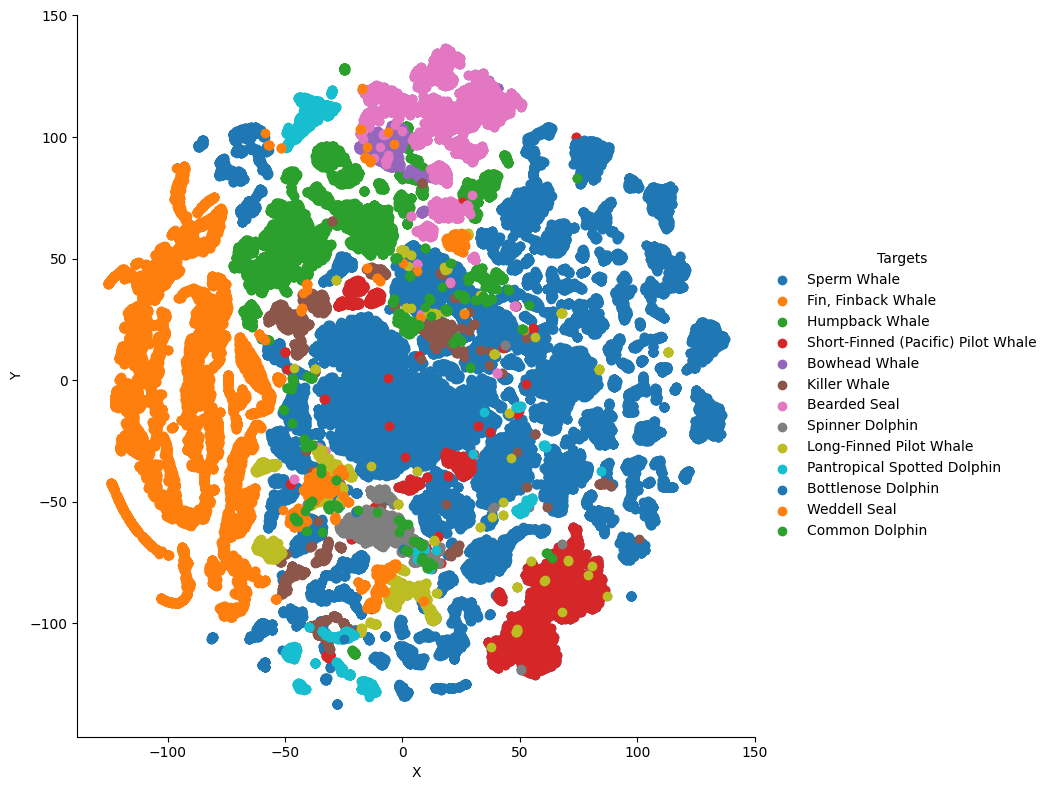

In [18]:
plt.figure(figsize=(10,8))
g = sns.FacetGrid(data=tsne_df, hue='Targets', height=8, palette="tab10")
g.map(plt.scatter, 'X', 'Y').add_legend()
plt.show()

## Training CNN

In [4]:
CNN_CACHE_DIR = os.path.join("data_cache", "CNN")
MODELS_METRICS_DIR = os.path.join("models_metrics")
PATIENCE = 3
if not os.path.exists(MODELS_METRICS_DIR):
    os.makedirs(MODELS_METRICS_DIR)

split_perc = {'train': 0.8, 'val': 0.2}

Training della CNN classica con le classi che contengono più di 1000 sample.

In [ ]:

n_classes_1000 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (0, 0), to_train=TO_TRAIN, cardinality=999)

Si ripete il training aggiungendo 10 classi per volta in ordine decrescente in numero di sample contenuti.

In [7]:
#Fino a classe 23
n_classes_plus_10 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_1000, 10), to_train=TO_TRAIN)

Added classes: ['White-sided Dolphin', 'Walrus', 'Clymene Dolphin', "Fraser's Dolphin", 'False Killer Whale', 'Striped Dolphin', 'West Indian Manatee', 'Ross Seal', 'Northern Right Whale', "Grampus, Risso's Dolphin"]
Total classes found: 23
Listing all image files path...
Creating and caching data split...
Processing train set with 68728 images...
train set processed and added to the dictionary.
Processing val set with 17182 images...
val set processed and added to the dictionary.
training
Epoch 1/50


KeyboardInterrupt: 

In [ ]:
#Fino a classe 33
n_classes_plus_20 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_plus_10, 10), to_train=TO_TRAIN)

In [ ]:
#Fino a classe 43
n_classes_plus_30 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_plus_20, 10), to_train=TO_TRAIN)

In [ ]:
#Fino all'ultima classe
n_classes_plus_rem = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_plus_30, 10), to_train=True)

## Output Plots

In [8]:
def get_class_metrics(row, all_classes_df, metrics_list):
    for metric in metrics_list:
        class_num = row['index']
        col_name = rf'{class_num}_{metric}'
        class_metrics = all_classes_df[col_name]
        row[metric] = class_metrics
    return row

def process_metrics(n_classes, training_date):
    all_classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, f'{training_date}_training', f'{n_classes}_CNN_metrics.csv'))
    all_classes_df = all_classes_df.loc[:, all_classes_df.columns.str.match(r'^\d')]
    last_epoch_metrics = all_classes_df.iloc[-1]

    classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, f'{training_date}_training', f'{n_classes}_label_to_index.csv'))

    metrics_list = ['precision', 'recall', 'f1-score', 'support']
    classes_df = classes_df.apply(get_class_metrics, axis=1, all_classes_df=last_epoch_metrics, metrics_list=metrics_list)
    classes_df['label'] = classes_df['label'].apply(lambda x: ' '.join(x.split(' ')[:2]) if len(x) > 20 else x)
    classes_df.to_csv(os.path.join(MODELS_METRICS_DIR, f'{training_date}_merged_metrics', f'{n_classes}_merged_metrics.csv'), index=False)

def metrics_plot_builder(metrics_df):
    metrics_list = ['precision', 'recall', 'f1-score']
    f = 1
    fig = plt.figure(figsize=(15, 15))
    for metric in metrics_list:
        axs = plt.subplot(2, 2, f)
        axs.bar(metrics_df['label'], metrics_df[metric], color="#87CEEB")
        for i, (metric_value, support) in enumerate(zip(metrics_df[metric], metrics_df['support'])):
            label_pos = metric_value - (metric_value/2) if metric_value > 0 else metric_value + 0.02
            plt.text(i, label_pos, f'n:{int(support)}', ha='center', va='bottom', fontsize=9, rotation=90)
        axs.set_xlabel('Class')
        axs.tick_params(axis='x', rotation=90)
        axs.set_ylabel(metric.capitalize())
        axs.set_title(f'{metric.capitalize()} per Class (ordered by Support - descending)')
        
        f += 1
    fig.tight_layout()
    return fig

In [10]:
curr_training_date = '15-09'
process_metrics(n_classes_1000, curr_training_date)
#process_metrics(n_classes_plus_10, curr_training_date)
#process_metrics(n_classes_plus_20, curr_training_date)
#process_metrics(n_classes_plus_30, curr_training_date)
#process_metrics(n_classes_plus_rem, curr_training_date)

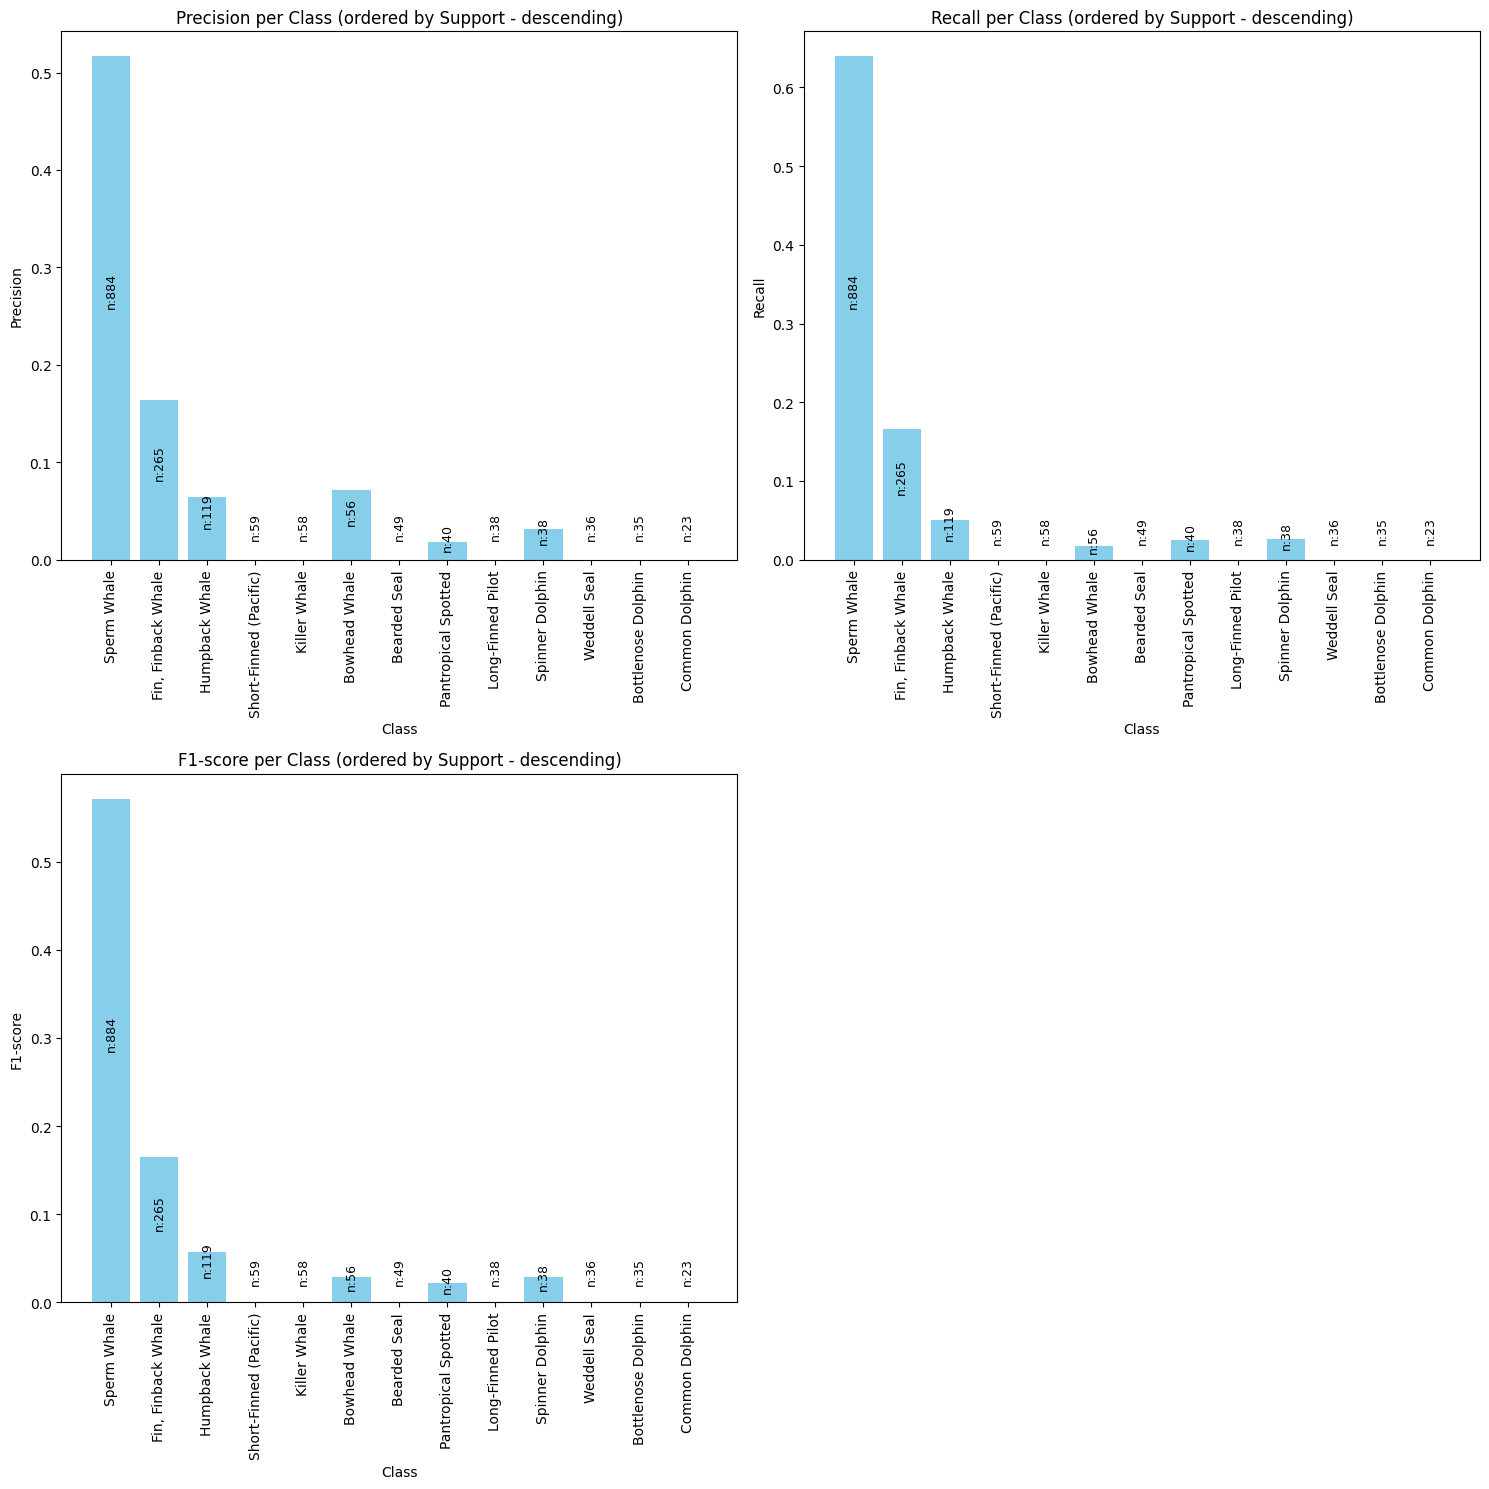

In [12]:
curr_metrics_date = '15-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_1000}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()

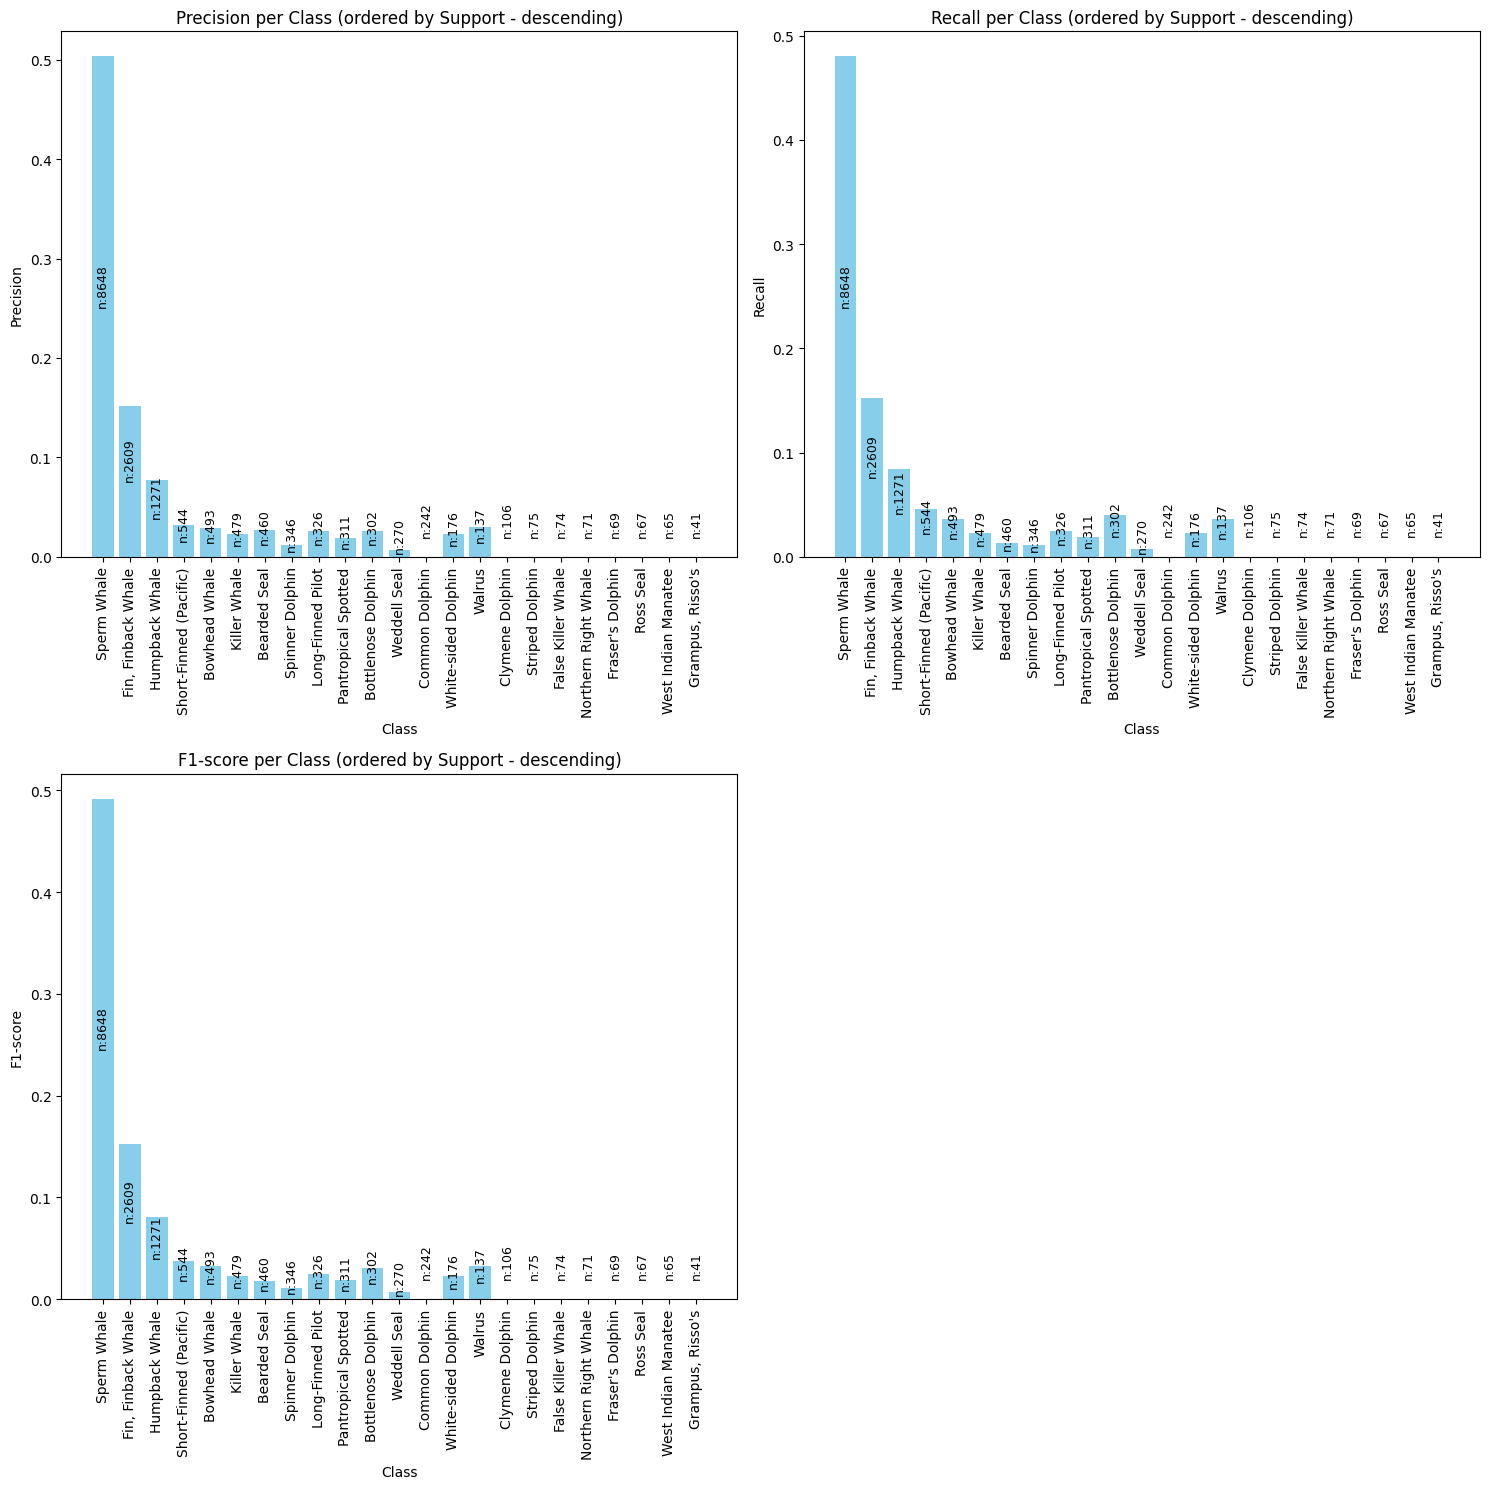

In [20]:
curr_metrics_date = '11-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_plus_10}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()

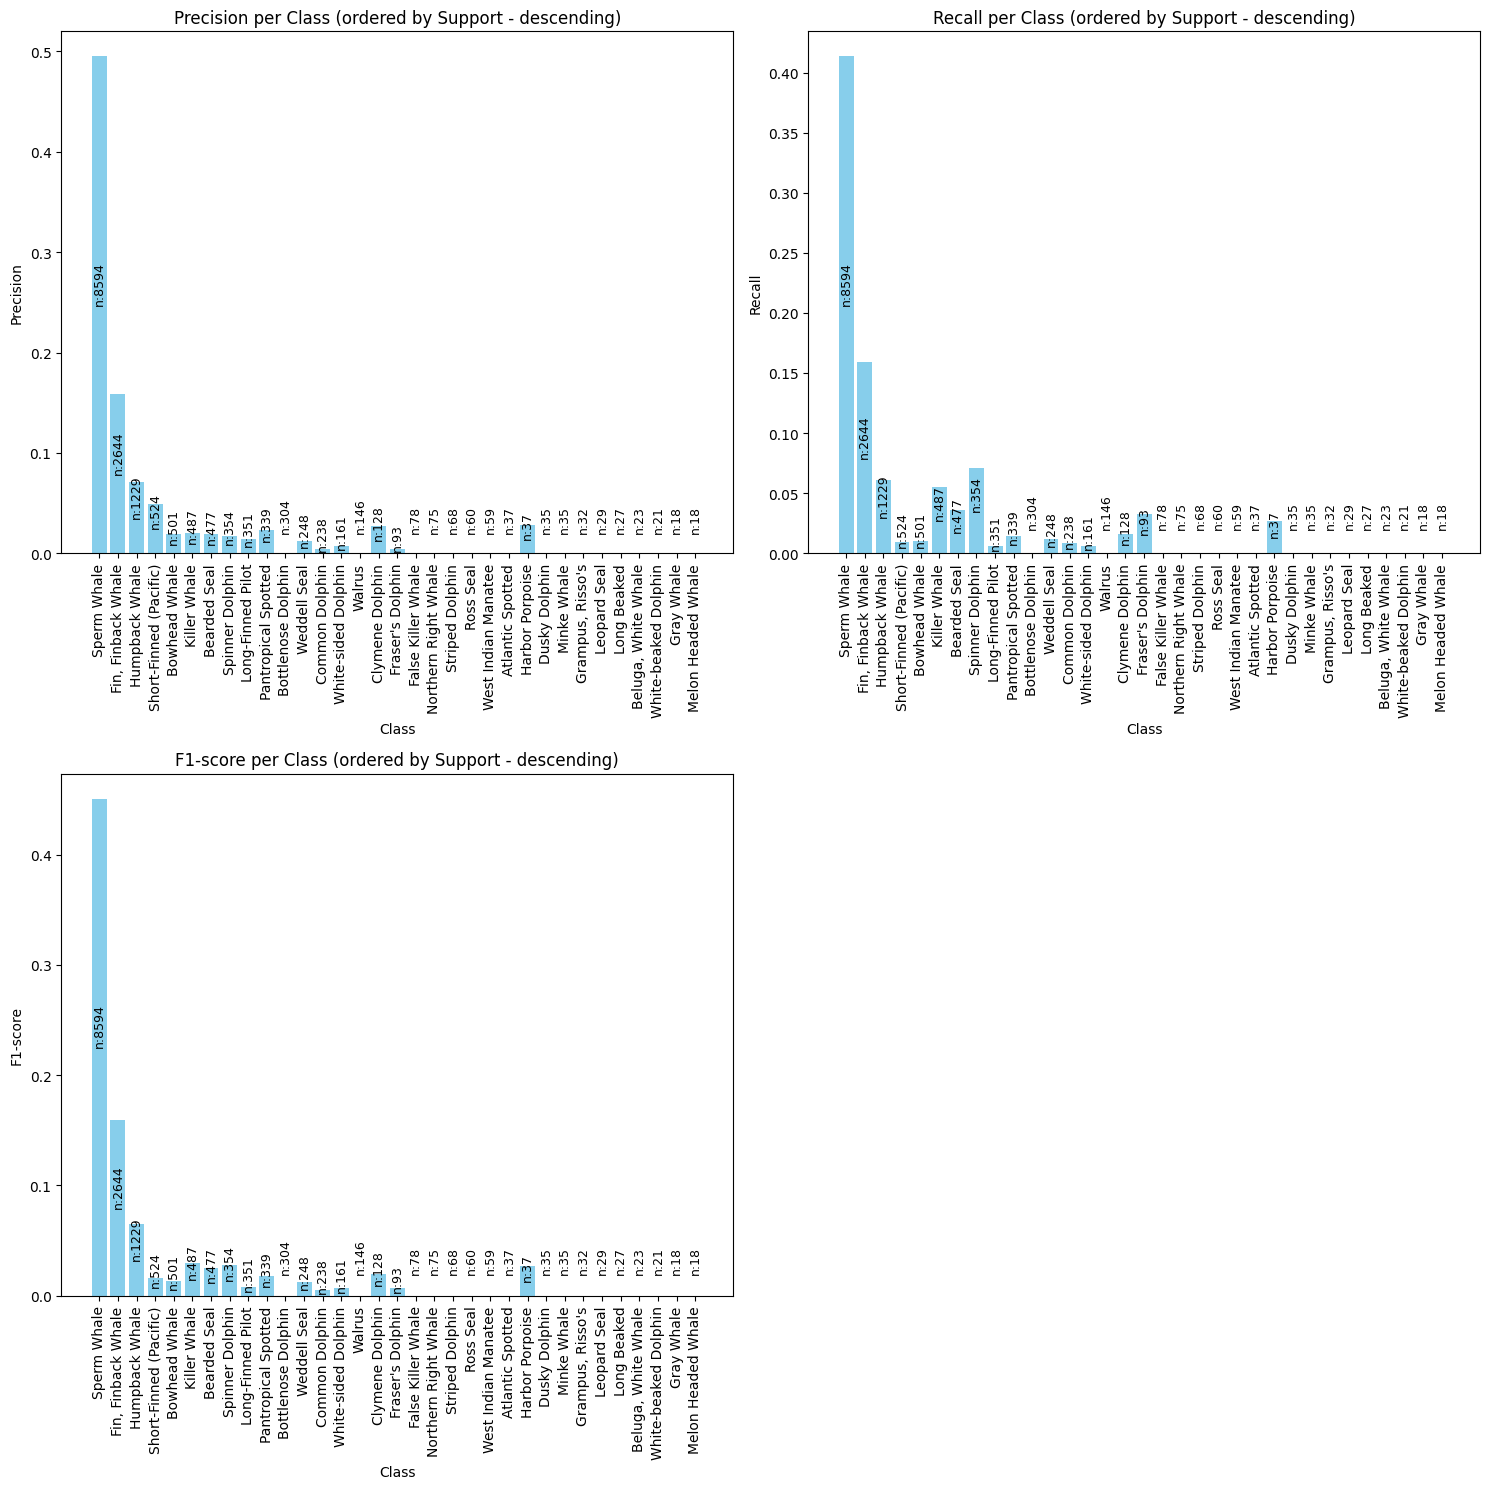

In [21]:
curr_metrics_date = '11-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_plus_20}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()

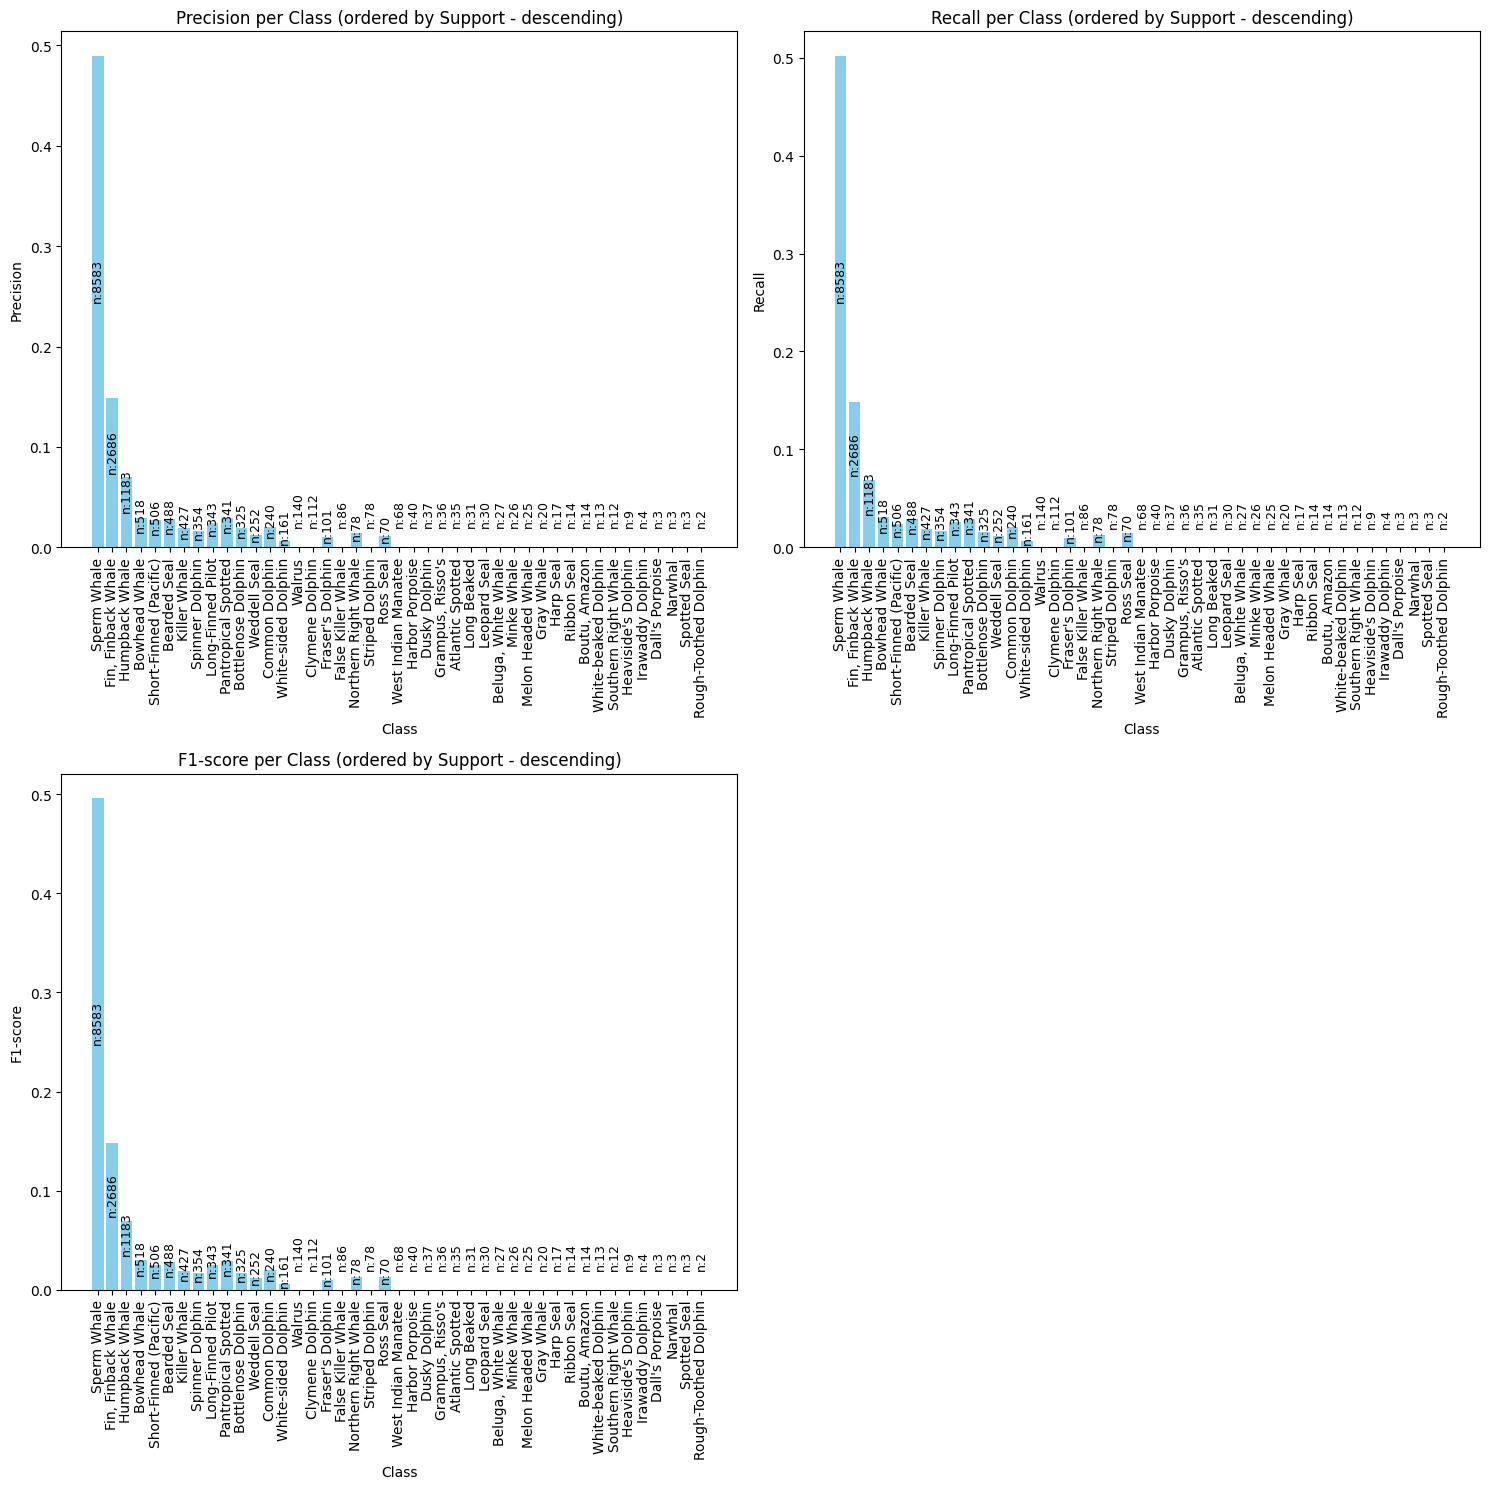

In [22]:
curr_metrics_date = '11-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_plus_30}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()

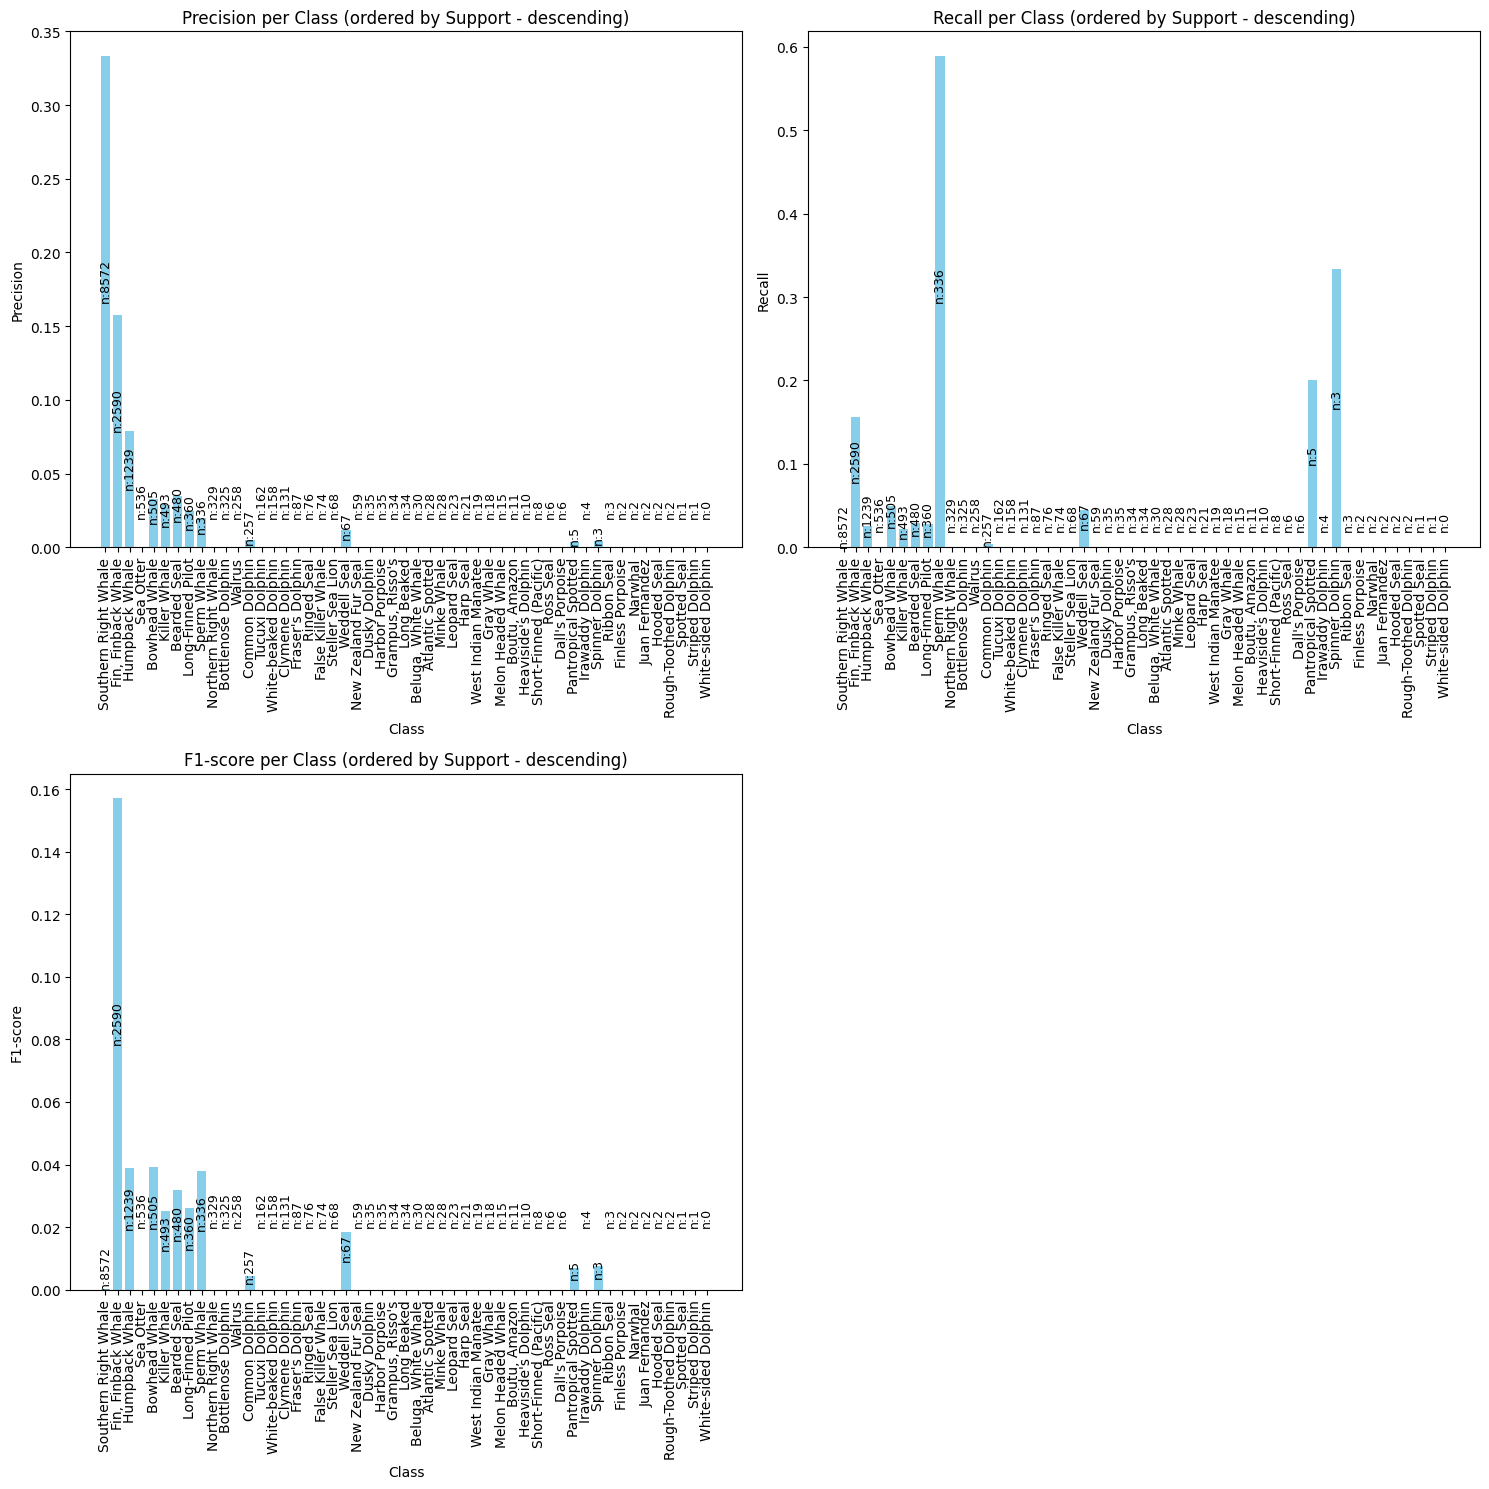

In [25]:
curr_metrics_date = '11-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_plus_rem}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()